# Running mode solver tasks in parallel

Mode solver simulations are typically fast because they are intrinsically 2D problems. However, in many cases, multiple mode solver simulations are required to understand mode behaviors in a waveguide, which can still take a significant amount of time if run sequentially. Tidy3D supports running a batch of mode solver tasks in parallel, very similar to [running a batch of FDTD simulations](https://www.flexcompute.com/tidy3d/examples/notebooks/ParameterScan/). 

This notebook demonstrates how to perform parallel mode solving using the example of calculating mode dispersion as a function of the lithium niobate (LN) strip waveguide width.

For a more focused mode solver tutorial, please refer to [here](https://www.flexcompute.com/tidy3d/examples/notebooks/ModeSolver/).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import waveguide

14:54:13 CET WARNING: Using canonical configuration directory at                
             '/home/marco/.config/tidy3d'. Found legacy directory at            
             '~/.tidy3d', which will be ignored. Remove it manually or run      
             'tidy3d config migrate --delete-legacy' to clean up.               

First, we define the basic parameters and materials to be used. Specifically, we are solving for a lithium niobate (LN) strip waveguide with a sidewall angle of 20 degrees and a thickness of 400 nm at a wavelength of 1550 nm. The waveguide sits on a silicon dioxide BOX, and the top cladding is air.

For convenience, we will directly use the available materials from the [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html). When defining the LN material, we need to specify the optical axis direction since LN is anisotropic, i.e. `td.material_library['LiNbO3']['Zelmon1997'](optical axis)`, where `optical axis = 1, 2, or 3` corresponds to the $x$-, $y$-, and $z$-axis of the simulation domain. In this case, the LN is X-cut with the mode propagating in the Y direction ($x$-axis of the simulation coordinate), so we set the optical axis to `1`, meaning the extraordinary refractive index is aligned with the $y$-axis of the simulation coordinates. 

In [2]:
lda0 = 1.55  # wavelength of interest

h_LN = 0.4  # lithium niobate waveguide thickness
sidewall_angle = 20  # sidewall angle in degree

LN = td.material_library["LiNbO3"]["Zelmon1997"](1)
SiO2 = td.material_library["SiO2"]["Palik_Lossless"]

To perform the sweep of the waveguide width, we need to generate a dictionary of mode solver tasks each with a different waveguide width configuration. To do so conveniently, we will use the [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/) as it eliminates the need to manually define the waveguide and BOX structures as well as the simulation domain and mode solving plane.  

In [3]:
w_LN_range = np.arange(0.5, 4.1, 0.1)  # waveguide width range
n_mode = 10  # number of modes to solve for

mode_solvers = {}
for w_LN in w_LN_range:
    # using the waveguide plugin to create a mode solver for each waveguide width configuration
    strip_waveguide = waveguide.RectangularDielectric(
        wavelength=lda0,
        core_width=w_LN,
        core_thickness=h_LN,
        sidewall_angle=np.deg2rad(sidewall_angle),
        core_medium=LN,
        clad_medium=td.Medium(),
        box_medium=SiO2,
        mode_spec=td.ModeSpec(
            num_modes=n_mode, target_neff=LN.nk_model(td.C_0 / lda0)[0], num_pml=(12, 12)
        ),
    )
    # add the mode solver to the dictionary
    mode_solvers[f"width={w_LN:.2f}"] = strip_waveguide.mode_solver

Once the list of mode solvers is created, we simply use the `run` method to run the entire batch of tasks in parallel. Alternatively, one can create a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) object first and run it with the [run()](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html#tidy3d.web.api.container.Batch.run) method. [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) provides a better management of the simulation files since one can save the batch information to file and load the batch at a later time.

In [4]:
# run mode solvers in parallel
batch_results = web.run(
    mode_solvers,  # dictionary of mode solvers
    path="data",  # path to store the result files
)

# alternative way to run the mode solvers in parallel is shown below
# batch = web.Batch(simulations=mode_solvers)
# batch_results = batch.run(path_dir="data")

Output()

14:54:38 CET Started working on Batch containing 36 tasks.

14:55:39 CET Maximum FlexCredit cost: 0.144 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after    
             completion.

Output()

14:58:43 CET Batch complete.

14:59:09 CET Loading simulation from                                            
             data/mo-f5941f2f-7038-4d8a-a4aa-a412179b860f.hdf5

14:59:11 CET Loading simulation from                                            
             data/mo-e2f49727-ad8e-4649-acc5-42cb8d1761cc.hdf5

14:59:13 CET Loading simulation from                                            
             data/mo-0a1edfd9-722d-47f2-a505-58b424333ee8.hdf5

14:59:14 CET Loading simulation from                                            
             data/mo-302ba81d-18ca-41dc-a9de-70eca9fd36b4.hdf5

14:59:15 CET Loading simulation from                                            
             data/mo-ef58dc67-5428-4151-9869-f6c91a9f9e03.hdf5

14:59:16 CET Loading simulation from                                            
             data/mo-96a4cc32-721d-43c9-a989-78a82f62a31a.hdf5

14:59:17 CET Loading simulation from                                            
             data/mo-0e735b90-0faf-46d4-877e-653f67588e8e.hdf5

14:59:18 CET Loading simulation from                                            
             data/mo-86eb2efe-a123-4453-a4bb-a07345cdd29c.hdf5

14:59:19 CET Loading simulation from                                            
             data/mo-fadd8037-5ec9-4375-a60c-7bca9b2141cd.hdf5

             Loading simulation from                                            
             data/mo-6623f9b7-c9d7-4dce-b540-9ed3f6bce20e.hdf5

14:59:20 CET Loading simulation from                                            
             data/mo-8152d9ed-5a9a-40bc-a122-08460f257f75.hdf5

14:59:21 CET Loading simulation from                                            
             data/mo-d4a9b954-748c-497b-b204-12cd678f82d3.hdf5

14:59:22 CET Loading simulation from                                            
             data/mo-5c164adb-5022-461a-83af-9df8a6a605d7.hdf5

14:59:23 CET Loading simulation from                                            
             data/mo-f82170f9-3e54-4608-aee3-99b268862d95.hdf5

14:59:24 CET Loading simulation from                                            
             data/mo-b932bc9c-0630-4c6e-951a-3971ed43d548.hdf5

14:59:25 CET Loading simulation from                                            
             data/mo-6dc6fac0-7e05-4fc6-ae1e-1c800bb7586b.hdf5

14:59:27 CET Loading simulation from                                            
             data/mo-05172351-96fe-4630-88f3-86450cfe337d.hdf5

14:59:28 CET Loading simulation from                                            
             data/mo-9a147b1b-451c-4b80-b156-9c87146cd6fe.hdf5

14:59:30 CET Loading simulation from                                            
             data/mo-f84ccf6a-1fdc-4ffe-85b2-1fc0f8943865.hdf5

14:59:31 CET Loading simulation from                                            
             data/mo-43d9d675-5d8c-47e5-b77e-1047fed09fec.hdf5

14:59:32 CET Loading simulation from                                            
             data/mo-af77c985-0bbf-48dd-b6ab-7cfb808f8033.hdf5

14:59:33 CET Loading simulation from                                            
             data/mo-d00729e1-dd46-45a9-921b-e185698efe72.hdf5

             Loading simulation from                                            
             data/mo-4e30095d-daef-4ae7-b370-4e29c870ad6c.hdf5

14:59:34 CET Loading simulation from                                            
             data/mo-b6dbce50-2715-48f6-a526-bec8566cc557.hdf5

14:59:35 CET Loading simulation from                                            
             data/mo-3ab0ab17-60e8-40a9-ae1f-befac91879b3.hdf5

14:59:36 CET Loading simulation from                                            
             data/mo-ec3a7886-2638-4602-9bae-238e87906ca1.hdf5

14:59:37 CET Loading simulation from                                            
             data/mo-5c4297f4-736b-4470-9152-113458afc6e8.hdf5

14:59:38 CET Loading simulation from                                            
             data/mo-35e6107b-4fd6-480d-ade1-a0bd849974ae.hdf5

14:59:39 CET Loading simulation from                                            
             data/mo-ac4f8e3f-0d89-45be-b86f-2f3d85a8b77d.hdf5

             Loading simulation from                                            
             data/mo-dfcbe39c-3e51-4246-be1c-442536c3ee55.hdf5

14:59:40 CET Loading simulation from                                            
             data/mo-c7fbcc71-b1a7-49ab-bad7-288ed11c5dcc.hdf5

14:59:42 CET Loading simulation from                                            
             data/mo-5019f2af-be5e-452f-831e-a380b78ab030.hdf5

14:59:44 CET Loading simulation from                                            
             data/mo-cf8b04c9-6beb-47f6-9f4c-f074370e28f6.hdf5

14:59:46 CET Loading simulation from                                            
             data/mo-12a788e9-b14e-4d36-894a-84de517429e9.hdf5

14:59:47 CET Loading simulation from                                            
             data/mo-79306634-3b48-40d8-a8bf-b226a64d7e61.hdf5

14:59:48 CET Loading simulation from                                            
             data/mo-e154cd6f-93b9-4237-aaf1-b2df82d343fb.hdf5

             Loading simulation from                                            
             data/mo-f5941f2f-7038-4d8a-a4aa-a412179b860f.hdf5

14:59:49 CET Loading simulation from                                            
             data/mo-e2f49727-ad8e-4649-acc5-42cb8d1761cc.hdf5

14:59:50 CET Loading simulation from                                            
             data/mo-0a1edfd9-722d-47f2-a505-58b424333ee8.hdf5

14:59:51 CET Loading simulation from                                            
             data/mo-302ba81d-18ca-41dc-a9de-70eca9fd36b4.hdf5

14:59:52 CET Loading simulation from                                            
             data/mo-ef58dc67-5428-4151-9869-f6c91a9f9e03.hdf5

14:59:53 CET Loading simulation from                                            
             data/mo-96a4cc32-721d-43c9-a989-78a82f62a31a.hdf5

14:59:54 CET Loading simulation from                                            
             data/mo-0e735b90-0faf-46d4-877e-653f67588e8e.hdf5

             Loading simulation from                                            
             data/mo-86eb2efe-a123-4453-a4bb-a07345cdd29c.hdf5

14:59:55 CET Loading simulation from                                            
             data/mo-fadd8037-5ec9-4375-a60c-7bca9b2141cd.hdf5

14:59:56 CET Loading simulation from                                            
             data/mo-6623f9b7-c9d7-4dce-b540-9ed3f6bce20e.hdf5

14:59:57 CET Loading simulation from                                            
             data/mo-8152d9ed-5a9a-40bc-a122-08460f257f75.hdf5

14:59:59 CET Loading simulation from                                            
             data/mo-d4a9b954-748c-497b-b204-12cd678f82d3.hdf5

15:00:01 CET Loading simulation from                                            
             data/mo-5c164adb-5022-461a-83af-9df8a6a605d7.hdf5

15:00:02 CET Loading simulation from                                            
             data/mo-f82170f9-3e54-4608-aee3-99b268862d95.hdf5

15:00:03 CET Loading simulation from                                            
             data/mo-b932bc9c-0630-4c6e-951a-3971ed43d548.hdf5

15:00:04 CET Loading simulation from                                            
             data/mo-6dc6fac0-7e05-4fc6-ae1e-1c800bb7586b.hdf5

15:00:05 CET Loading simulation from                                            
             data/mo-05172351-96fe-4630-88f3-86450cfe337d.hdf5

15:00:06 CET Loading simulation from                                            
             data/mo-9a147b1b-451c-4b80-b156-9c87146cd6fe.hdf5

15:00:07 CET Loading simulation from                                            
             data/mo-f84ccf6a-1fdc-4ffe-85b2-1fc0f8943865.hdf5

15:00:08 CET Loading simulation from                                            
             data/mo-43d9d675-5d8c-47e5-b77e-1047fed09fec.hdf5

15:00:09 CET Loading simulation from                                            
             data/mo-af77c985-0bbf-48dd-b6ab-7cfb808f8033.hdf5

15:00:10 CET Loading simulation from                                            
             data/mo-d00729e1-dd46-45a9-921b-e185698efe72.hdf5

             Loading simulation from                                            
             data/mo-4e30095d-daef-4ae7-b370-4e29c870ad6c.hdf5

15:00:11 CET Loading simulation from                                            
             data/mo-b6dbce50-2715-48f6-a526-bec8566cc557.hdf5

15:00:12 CET Loading simulation from                                            
             data/mo-3ab0ab17-60e8-40a9-ae1f-befac91879b3.hdf5

15:00:13 CET Loading simulation from                                            
             data/mo-ec3a7886-2638-4602-9bae-238e87906ca1.hdf5

15:00:15 CET Loading simulation from                                            
             data/mo-5c4297f4-736b-4470-9152-113458afc6e8.hdf5

15:00:17 CET Loading simulation from                                            
             data/mo-35e6107b-4fd6-480d-ade1-a0bd849974ae.hdf5

15:00:19 CET Loading simulation from                                            
             data/mo-ac4f8e3f-0d89-45be-b86f-2f3d85a8b77d.hdf5

             Loading simulation from                                            
             data/mo-dfcbe39c-3e51-4246-be1c-442536c3ee55.hdf5

15:00:20 CET Loading simulation from                                            
             data/mo-c7fbcc71-b1a7-49ab-bad7-288ed11c5dcc.hdf5

15:00:21 CET Loading simulation from                                            
             data/mo-5019f2af-be5e-452f-831e-a380b78ab030.hdf5

15:00:22 CET Loading simulation from                                            
             data/mo-cf8b04c9-6beb-47f6-9f4c-f074370e28f6.hdf5

15:00:23 CET Loading simulation from                                            
             data/mo-12a788e9-b14e-4d36-894a-84de517429e9.hdf5

             Loading simulation from                                            
             data/mo-79306634-3b48-40d8-a8bf-b226a64d7e61.hdf5

15:00:24 CET Loading simulation from                                            
             data/mo-e154cd6f-93b9-4237-aaf1-b2df82d343fb.hdf5

After the batch of tasks is finished, we are ready to extract the results. We can plot all the mode profiles to inspect each mode at each waveguide width. As a demonstration, we plot all 10 modes with the widest waveguide.  

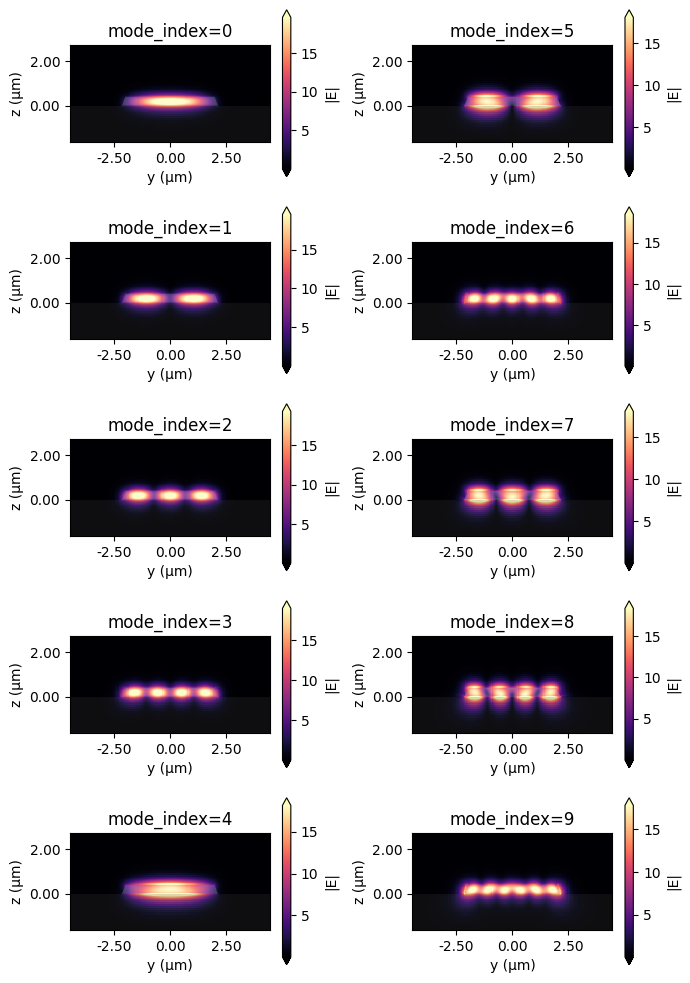

In [5]:
# plot all mode profiles of the widest waveguide
fig, ax = plt.subplots(5, 2, figsize=(7, 10), tight_layout=True)
for i in range(n_mode):
    mode_solvers[f"width={w_LN_range[-1]:.2f}"].plot_field(
        "E", "abs", mode_index=i, ax=ax[i % 5][i // 5]
    )
    ax[i % 5][i // 5].set_title(f"mode_index={i}")

From the mode profiles, we can distinguish fundamental modes and higher order modes. To be more quantitative, we can extract other mode information. For example, we can extract the effective indices and polarization fractions of the modes. 

In [6]:
# extract the effective index and polarization fraction
n_eff = np.array([result.n_eff[0] for _, result in batch_results.items()]).T
te_fraction = np.array([result.pol_fraction.te.data[0] for _, result in batch_results.items()]).T

Once we extract the information, we can plot them to visualize the mode dispersion. Here we plot the effective indices first as curves and then as scatterers with color, where the color indicates the polarization. Red corresponds to quasi-TE modes and blue corresponds to quasi-TM modes. We can see at a few places mode hybridization occurs. For example, at around 1.5 μm waveguide width, the TM0 and TE1 modes hybridize. This hybridization is often utilized to make mode converters for polarization control, as demonstrated in the [polarization splitter rotator](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/) example. 

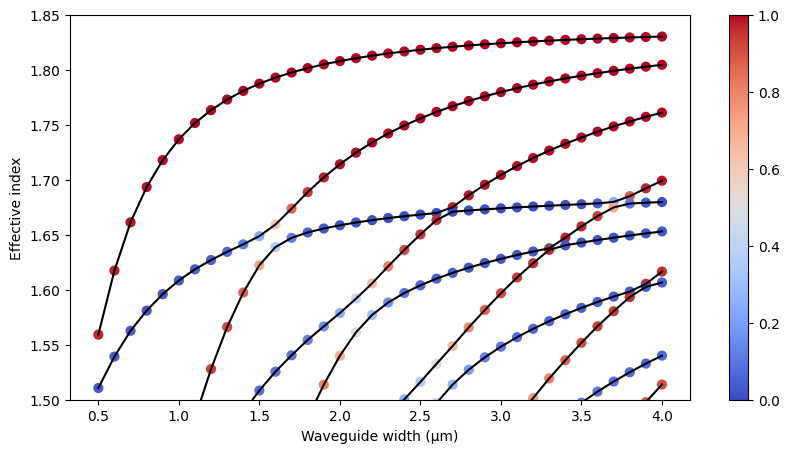

In [7]:
# plot each mode dispersion curve and polarization as colored scatterers
plt.figure(figsize=(10, 5))
for i in range(n_mode):
    plt.plot(w_LN_range, n_eff[i], c="black")
    plt.scatter(w_LN_range, n_eff[i], c=te_fraction[i], cmap="coolwarm", s=40, vmin=0, vmax=1)

plt.ylim(1.5, 1.85)
plt.xlabel("Waveguide width (μm)")
plt.ylabel("Effective index")
plt.colorbar()
plt.show()